In [51]:
# used to supress display of warnings
import warnings
warnings.filterwarnings("ignore")
# os is used to provide a way of using operating system dependent functionality
# We use it for setting working folder
import os

# Pandas is used for data manipulation and analysis
import pandas as pd 

# Numpy is used for large, multi-dimensional arrays and matrices, along with mathematical operators on these arrays
import numpy as np

# Matplotlib is a data visualization library for 2D plots of arrays, built on NumPy arrays 
# and designed to work with the broader SciPy stack
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import pyplot

# Seaborn is based on matplotlib, which aids in drawing attractive and informative statistical graphics.
import seaborn as sns

#RS
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from surprise import SVD, KNNWithMeans
from surprise import accuracy, Dataset,Reader
from collections import defaultdict
from surprise.model_selection import train_test_split, cross_validate



In [3]:
#Importing Part 1 csv file
df1 = pd.read_csv('phone_user_review_file_1.csv')
# df1.head()

In [4]:
#Importing Part 2 csv file
df2 = pd.read_csv('phone_user_review_file_2.csv')
# df2.head()

In [5]:
#Importing Part 3 csv file
df3 = pd.read_csv('phone_user_review_file_3.csv')
# df3.head()

In [6]:
#Importing Part 4 csv file
df4 = pd.read_csv('phone_user_review_file_4.csv')
# df4.head()

In [7]:
#Importing Part 5 csv file
df5 = pd.read_csv('phone_user_review_file_5.csv')
# df5.head()

In [8]:
Fdf = pd.concat([df1,df2,df3,df4,df5])

In [9]:
Fdf.head() # combined dataframe

,phone_url,date,lang,country,source,domain,score,score_max,extract,author,product
0,/cellphones/samsung-galaxy-s8/,5/2/2017,en,us,Verizon Wireless,verizonwireless.com,10.0,10.0,As a diehard Samsung fan who has had every Sam...,CarolAnn35,Samsung Galaxy S8
1,/cellphones/samsung-galaxy-s8/,4/28/2017,en,us,Phone Arena,phonearena.com,10.0,10.0,Love the phone. the phone is sleek and smooth ...,james0923,Samsung Galaxy S8
2,/cellphones/samsung-galaxy-s8/,5/4/2017,en,us,Amazon,amazon.com,6.0,10.0,Adequate feel. Nice heft. Processor's still sl...,R. Craig,"Samsung Galaxy S8 (64GB) G950U 5.8"" 4G LTE Unl..."
3,/cellphones/samsung-galaxy-s8/,5/2/2017,en,us,Samsung,samsung.com,9.2,10.0,Never disappointed. One of the reasons I've be...,Buster2020,Samsung Galaxy S8 64GB (AT&T)
4,/cellphones/samsung-galaxy-s8/,5/11/2017,en,us,Verizon Wireless,verizonwireless.com,4.0,10.0,I've now found that i'm in a group of people t...,S Ate Mine,Samsung Galaxy S8


In [10]:
Fdf.shape # Rows and Columns

(1251296, 11)

In [11]:
Fdf.dtypes

phone_url     object
date          object
lang          object
country       object
source        object
domain        object
score        float64
score_max    float64
extract       object
author        object
product       object
dtype: object

In [12]:
Fdf.duplicated().any() 

True

In [13]:
print(Fdf.isna().sum())
print()
print('Total null values',Fdf.isna().sum().sum())

phone_url        0
date             0
lang             0
country          0
source           0
domain           0
score        51817
score_max    51817
extract      16473
author       50145
product          1
dtype: int64

Total null values 170253


In [14]:
#1000000 samples

Fdf_sampled = Fdf.sample(n=1000000,random_state=612)

In [15]:
Fdf_sampled.shape

(1000000, 11)

In [16]:
relevant_features=['author','product','score']

In [17]:
revs1 = Fdf_sampled.copy()

# Delete data which is not useful anymore, to save memory

# Step1: remove irrelevant features
revs1 = revs1.loc[:,relevant_features]
print(f'Step1: revs1 Shape after removing irrelevant features: Rows: {revs1.shape[0]} and Columns: {revs1.shape[1]}\n')

# Step2: Round-off score feature to nearest integer
revs1['score'] = revs1['score'].round(0).astype('Int64')
print('Step2: Round-off: Unique values in the "score" feature(after rounding-off): \n',list(revs1.score.unique()))

# Step3: Impute missing values in score feature with median
revs1['score'] = revs1['score'].fillna(revs1['score'].median())
print('\nStep3: Imputation of "score"  with median and "author" with "Anonymous"')

# Step4: remove samples with missing values in 'Product' and 'author' feature and also 'Anonymous' values
revs1.dropna(inplace=True)
revs1 = revs1[revs1["author"] != 'Anonymous']
print(f'\nStep4: revs1 Shape(after removing missing values): Rows: {revs1.shape[0]} and Columns: {revs1.shape[1]}\n')

# Step5: remove duplicates, if any
revs1 = revs1.drop_duplicates()
print(f'Step5: revs1 Shape(after removing duplicates): Rows: {revs1.shape[0]} and Columns: {revs1.shape[1]}\n')

print(f'Overall {round(100 - revs1.shape[0]*100/Fdf.shape[0],2)}% samples are dropped\n')
revs1.head()

Step1: revs1 Shape after removing irrelevant features: Rows: 1000000 and Columns: 3

Step2: Round-off: Unique values in the "score" feature(after rounding-off): 
 [6, 10, 8, 9, 2, 4, <NA>, 7, 5, 3, 1, 0]

Step3: Imputation of "score"  with median and "author" with "Anonymous"

Step4: revs1 Shape(after removing missing values): Rows: 958378 and Columns: 3

Step5: revs1 Shape(after removing duplicates): Rows: 859176 and Columns: 3

Overall 31.34% samples are dropped



,author,product,score
133960,VIPIN,Sony Xperia C (Black),6
79886,Saurabh Pandey,"Sony Xperia T2 Ultra (Black, 8 GB)",10
2553,sathish,"HP Slate 6 Voice Tab (6inch,16GB,Wi-Fi+3G+Voic...",8
115075,Fred,Huawei P8 grijs / 16 GB,9
42103,satish reddy,"Apple iPhone 5S (Silver, 16 GB)",10


In [18]:
revs1.shape

(859176, 3)

Distribution of number of ratings per item (Clipped at 10): 
 OnePlus 3 (Graphite, 64 GB)               1770
Lenovo Vibe K4 Note (White,16GB)          1679
Lenovo Vibe K4 Note (Black, 16GB)         1478
OnePlus 3 (Soft Gold, 64 GB)              1441
Samsung Galaxy J3 (8GB)                   1419
Samsung Galaxy S6 zwart / 32 GB           1399
Samsung Galaxy S7 edge 32GB (Verizon)     1382
Samsung Galaxy S7 edge 32GB (T-Mobile)    1305
Nokia 5800 XpressMusic                    1302
Samsung Galaxy S7 32GB (Verizon)          1271
Name: product, dtype: int64


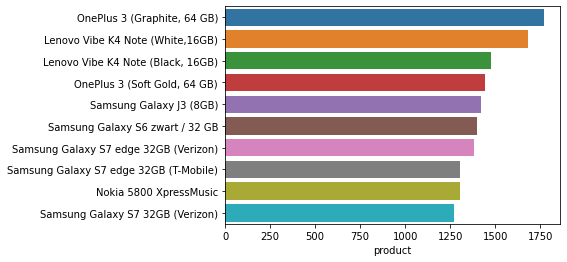

In [19]:
product = revs1['product'].value_counts()[:10]
print('Distribution of number of ratings per item (Clipped at 10): \n',product)
sns.barplot(y=product.index,x=product)
# plt.tight_layout()
plt.show()

Distribution of number of ratings per user(Clipped at 10): 
 Amazon Customer    14185
Cliente Amazon      5593
Client d'Amazon     2377
Amazon Kunde        1704
David                711
Alex                 625
Marco                554
Александр            543
Daniel               541
e-bit                516
Name: author, dtype: int64


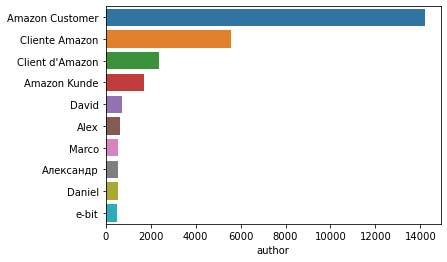

In [20]:
users = revs1['author'].value_counts(dropna=False)[:10]
print('Distribution of number of ratings per user(Clipped at 10): \n',users)
users.index = users.index.map(str)
sns.barplot(y=users.index,x=users)
# plt.tight_layout()
plt.show()

####  We see active user are Amazon customer

In [21]:
from colorama import Fore, Back, Style
print(Fore.YELLOW + "The total phones are",Style.RESET_ALL,f"{revs1['product'].count()},", Fore.BLUE + "from those the unique types are", Style.RESET_ALL, f"{revs1['product'].value_counts().shape[0]}.")


The total phones are  859176, from those the unique types are  48816.


In [22]:
print(Fore.YELLOW + "The total users are",Style.RESET_ALL,f"{revs1['author'].count()},", Fore.BLUE + "from those the unique types are", Style.RESET_ALL, f"{revs1['author'].value_counts().shape[0]}.")


The total users are  859176, from those the unique types are  581866.


In [23]:
Fdf_need = revs1

In [24]:
pd.DataFrame(Fdf_need.groupby('product')['score'].mean().sort_values(ascending=False).head(10)) # top rated features

,score
product,
金屬 + 皮革 = 質感滿分 Wave 723 詳測及心得,10.0
"Huawei Honor 8 (5.20"", 32GB, Dual SIM, 12MP, Black)",10.0
Samsung SGH-U900,10.0
Huawei Honor 7,10.0
Huawei Honor 7 3 + 64GB de huellas digitales 4G LTE Dual Sim completa Activo Android 5.0 Octa Core 2.2GHz 5.2 pulgadas FHD 8 + 20MP Gary,10.0
Huawei Honor 7 3+64GB Fingerprint 4G LTE Dual Sim Full Active Android 5.0 Octa Core 2.2GHz 5.2 inch FHD 8+20MP Argento,10.0
Huawei Honor 7 3+64GB Fingerprint 4G LTE Dual Sim Full Active Android 5.0 Octa Core 2.2GHz 5.2 inch FHD 8+20MP Grigio,10.0
Huawei Honor 7 3+64GB Fingerprint 4G LTE Dual Sim Full Active Android 5.0 Octa Core 2.2GHz 5.2 inch FHD 8+20MP...,10.0
"Samsung SGH-U800 Soul Handy (3MP Kamera, Bluetooth, MP3-Player) pink",10.0


In [25]:
# Top 10 users based on rating
most_rated = Fdf_need.groupby('author').size().sort_values(ascending=False)[:10]
most_rated

author
Amazon Customer    14185
Cliente Amazon      5593
Client d'Amazon     2377
Amazon Kunde        1704
David                711
Alex                 625
Marco                554
Александр            543
Daniel               541
e-bit                516
dtype: int64

In [26]:
# product with more than 50 rating
prodcount = pd.value_counts(Fdf_need['product'])
prodcount

OnePlus 3 (Graphite, 64 GB)                                                                                                                  1770
Lenovo Vibe K4 Note (White,16GB)                                                                                                             1679
Lenovo Vibe K4 Note (Black, 16GB)                                                                                                            1478
OnePlus 3 (Soft Gold, 64 GB)                                                                                                                 1441
Samsung Galaxy J3 (8GB)                                                                                                                      1419
                                                                                                                                             ... 
Motorola Moto G (2ª Geração) DTV Colors Preto TV Digital Dual Chip Proc Quad Core 1.2GHz Tela 5" Memória 16GB Acompanha 2 Ca

In [27]:
# user given rating more than 50

usercount = pd.value_counts(Fdf_need['author'])
usercount

Amazon Customer     14185
Cliente Amazon       5593
Client d'Amazon      2377
Amazon Kunde         1704
David                 711
                    ...  
the Jackel              1
Perruzza Nicolas        1
rebeca hernandez        1
Temistocle Petit        1
Все нормально           1
Name: author, Length: 581866, dtype: int64

In [28]:
# 3. Select data with products having >50 ratings and users who have given > 50 ratings
author50 = revs1['author'].value_counts()
author50 = author50[author50>50].index.tolist() # list of authors with > 50 ratings
print('Number of authors who have given >50 rating: ', len(author50))

product50 = revs1['product'].value_counts()
product50 = product50[product50>50].index.tolist() # list of products with > 50 ratings
print('Number of products with >50 rating: ', len(product50))

revs_50 = revs1[(revs1['author'].isin(author50)) & (revs1['product'].isin(product50))]
print(f'\nrevs_50: Rows: {revs_50.shape[0]} and Columns: {revs_50.shape[1]}\n')
del author50, product50
revs_50.head()

Number of authors who have given >50 rating:  599
Number of products with >50 rating:  3927

revs_50: Rows: 42887 and Columns: 3



,author,product,score
115075,Fred,Huawei P8 grijs / 16 GB,9
36493,Ray,"Samsung Galaxy S7 goud, roze / 32 GB",10
110686,Amazon Customer,"ZTE Nubia Z9 Mini (Black, 16GB)",10
168817,JC,Samsung Galaxy S4 mini i9195 Sim Free Smartpho...,10
160998,einem Kunden,"Samsung Galaxy A3 (2016) - A310F Smartphone, 1...",10


## Popularity Based Recommendation Systems

### Top 5 Mobile Phone for Recommendation 

In [29]:
def popularity_rec(data):
    ratings_mean_count = pd.DataFrame(data.groupby('product')['score'].mean())
    ratings_mean_count['rating_counts'] = data.groupby('product')['score'].count()
    ratings_mean_count = ratings_mean_count.sort_values(by=['score','rating_counts'], ascending=[False,False])
    print('Top 5 recommendations for the products are: \n')
    display(ratings_mean_count.head())
    return

In [30]:
# Using the data from the most popular phones amongst the most frequent users
popularity_rec(revs_50)

Top 5 recommendations for the products are: 



,score,rating_counts
product,,
ASUS ZenFone 3 Max ZC520TL 16GB (серый),10.0,33
ASUS ZenFone 3 Max ZC520TL 16GB (серебристый),10.0,30
Samsung Galaxy Note5,10.0,30
ASUS ZenFone 3 Max ZC520TL 16GB (золотистый),10.0,28
Nokia E51 Cep Telefonu,10.0,18


In [31]:
# if we consider the original data (excluding 'Anonymous' users)
popularity_rec(revs1)

Top 5 recommendations for the products are: 



,score,rating_counts
product,,
SAMSUNG Player Star 2,10.0,491
SAMSUNG Galaxy S,10.0,317
NOKIA E71 Noir,10.0,278
Apple iPhone 4 16Go Noir,10.0,208
SAMSUNG Galaxy Ace,10.0,202


## Collaborative_Filtering

In [39]:
# Rearrange columns for SVD and prepare train and testsets
data = Dataset.load_from_df(revs_50[['author','product','score']], Reader(rating_scale=(1, 10)))
trainset, testset = train_test_split(data, test_size=.25,random_state=0)

print('top 3 values from trainset: \n')
for key,value in {k: v for k, v in trainset.ur.items() if k <= 2}.items(): print(key,'-> ',value,'\n')
print('\ntop 3 values from testset: ', *testset[0:3], sep='\n\n')

top 3 values from trainset: 

0 ->  [(0, 2.0), (13, 2.0), (30, 10.0), (36, 8.0), (38, 2.0), (41, 6.0), (44, 10.0), (45, 6.0), (53, 4.0), (57, 2.0), (70, 2.0), (78, 2.0), (89, 6.0), (100, 6.0), (117, 10.0), (124, 4.0), (127, 2.0), (137, 10.0), (148, 8.0), (155, 8.0), (156, 4.0), (194, 6.0), (205, 8.0), (207, 8.0), (214, 2.0), (227, 8.0), (231, 10.0), (233, 10.0), (236, 6.0), (237, 10.0), (263, 8.0), (269, 10.0), (275, 10.0), (287, 4.0), (290, 6.0), (297, 10.0), (299, 10.0), (307, 2.0), (262, 4.0), (316, 8.0), (319, 10.0), (322, 2.0), (341, 8.0), (344, 8.0), (363, 2.0), (374, 2.0), (384, 8.0), (393, 6.0), (395, 10.0), (401, 8.0), (404, 10.0), (412, 6.0), (428, 10.0), (440, 6.0), (442, 8.0), (444, 6.0), (448, 10.0), (262, 8.0), (453, 2.0), (50, 2.0), (456, 2.0), (460, 4.0), (462, 8.0), (205, 4.0), (465, 2.0), (477, 2.0), (483, 10.0), (486, 8.0), (493, 10.0), (498, 10.0), (510, 10.0), (512, 8.0), (514, 2.0), (517, 10.0), (529, 10.0), (540, 2.0), (361, 2.0), (543, 4.0), (545, 4.0), (324, 2.

In [40]:
# Objective: To get top_n recommendation for each user
def get_top_n(predictions, n=5):
    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the n highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [41]:
%%time
# fit and predict using svd
def svd_func(train, test):
    svd = SVD(random_state=0)
    svd.fit(train)
    svd_pred = svd.test(test)
    return svd_pred, svd

svd_pred, svd = svd_func(trainset,testset)
print('First few prediction values: \n',svd_pred[0:2])
print('\nRMSE value(test-set): ',round(accuracy.rmse(svd_pred),2),'\n') # compute RMSE
svd_rmse = round(accuracy.rmse(svd_pred),2)

First few prediction values: 
 [Prediction(uid='Daniel', iid='Samsung \u200bSamsung Galaxy A3 Smartphone (12 cm (4,71 Zoll) HD Super AMOLED Touch-Display, 16 GB, Android 5.1) pink-gold', r_ui=4.0, est=9.911745119771156, details={'was_impossible': False}), Prediction(uid='Frank', iid='BlackBerry Passport Factory Unlocked Cellphone, 32GB, Black', r_ui=10.0, est=7.664589836281861, details={'was_impossible': False})]
RMSE: 2.8451

RMSE value(test-set):  2.85 

RMSE: 2.8451
Wall time: 6 s


### KNNwithMeans - Item based

In [42]:
%%time
# fit and predict using knn
def knn_item(train, test):
    knn_i = KNNWithMeans(k=50, sim_options={'name': 'pearson_baseline', 'user_based': False})
    knn_i.fit(train)
    knn_i_pred = knn_i.test(test)
    return knn_i_pred, knn_i

knn_i_pred, knn_i = knn_item(trainset, testset)
print('First few prediction values: \n',knn_i_pred[0:2])
print('\nRMSE value(Item-based Model, test-set): ',round(accuracy.rmse(knn_i_pred),2),'\n') # compute RMSE
knn_i_rmse = round(accuracy.rmse(knn_i_pred),2)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
First few prediction values: 
 [Prediction(uid='Daniel', iid='Samsung \u200bSamsung Galaxy A3 Smartphone (12 cm (4,71 Zoll) HD Super AMOLED Touch-Display, 16 GB, Android 5.1) pink-gold', r_ui=4.0, est=9.823009114762003, details={'actual_k': 50, 'was_impossible': False}), Prediction(uid='Frank', iid='BlackBerry Passport Factory Unlocked Cellphone, 32GB, Black', r_ui=10.0, est=8.562935948856119, details={'actual_k': 18, 'was_impossible': False})]
RMSE: 3.0401

RMSE value(Item-based Model, test-set):  3.04 

RMSE: 3.0401
Wall time: 21.6 s


### KNNwithMeans - User based

In [43]:
%%time
# fit and predict using knn
def knn_user(train, test):
    knn_u = KNNWithMeans(k=50, sim_options={'name': 'pearson_baseline', 'user_based': True})
    knn_u.fit(train)
    knn_u_pred = knn_u.test(test)
    return knn_u_pred, knn_u

knn_u_pred, knn_u = knn_user(trainset, testset)
print('First few prediction values: \n',knn_u_pred[0:2])
print('\nRMSE value(User-based Model, test-set): ',round(accuracy.rmse(knn_u_pred),2),'\n') # compute RMSE
knn_u_rmse = round(accuracy.rmse(knn_u_pred),2)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
First few prediction values: 
 [Prediction(uid='Daniel', iid='Samsung \u200bSamsung Galaxy A3 Smartphone (12 cm (4,71 Zoll) HD Super AMOLED Touch-Display, 16 GB, Android 5.1) pink-gold', r_ui=4.0, est=9.973224808604188, details={'actual_k': 3, 'was_impossible': False}), Prediction(uid='Frank', iid='BlackBerry Passport Factory Unlocked Cellphone, 32GB, Black', r_ui=10.0, est=7.6687446855552235, details={'actual_k': 2, 'was_impossible': False})]
RMSE: 3.1267

RMSE value(User-based Model, test-set):  3.13 

RMSE: 3.1267
Wall time: 1.81 s


<AxesSubplot:>

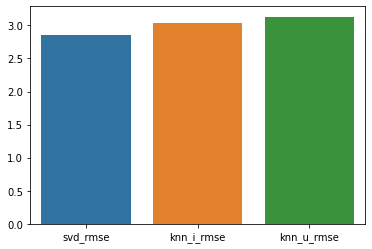

In [44]:
# Comparison of RMSE scores from different collaorative algorithms
sns.barplot(x=['svd_rmse','knn_i_rmse', 'knn_u_rmse'],y=[svd_rmse,knn_i_rmse, knn_u_rmse])

## On comparing RMSE - > SVD has better performance, hence we go with svd for future use

# Average rating for test user

In [45]:
svd_pred_df=pd.DataFrame(svd_pred, columns=['uid', 'iid', 'rui', 'est', 'details'])
print('average prediction for test users: ',svd_pred_df['est'].mean())
print('average rating  by test users: ',svd_pred_df['rui'].mean())
print('average prediction error for test users: ',(svd_pred_df['rui']-svd_pred_df['est']).abs().mean())

average prediction for test users:  7.889403395120866
average rating  by test users:  7.937045327364298
average prediction error for test users:  2.2289078245355625


In [46]:
knn_i_pred_df=pd.DataFrame(knn_i_pred, columns=['uid', 'iid', 'rui', 'est', 'details'])
print('average prediction for test users: ',knn_i_pred_df['est'].mean())
print('average rating  by test users: ',knn_i_pred_df['rui'].mean())
print('average prediction error for test users: ',(knn_i_pred_df['rui']-knn_i_pred_df['est']).abs().mean())

average prediction for test users:  7.7755901059307195
average rating  by test users:  7.937045327364298
average prediction error for test users:  2.348171430886567


In [47]:
knn_u_pred_df=pd.DataFrame(knn_u_pred, columns=['uid', 'iid', 'rui', 'est', 'details'])
print('average prediction for test users: ',knn_u_pred_df['est'].mean())
print('average rating  by test users: ',knn_u_pred_df['rui'].mean())
print('average prediction error for test users: ',(knn_u_pred_df['rui']-knn_u_pred_df['est']).abs().mean())

average prediction for test users:  7.840027415252003
average rating  by test users:  7.937045327364298
average prediction error for test users:  2.370929164530049


## Findings and Inferences

1. Most popuar phone over all - SAMSUNG Player Star 2 
2. From most frequnent user - ASUS ZenFone 3 Max ZC520TL 16GB (серый)
3. Most of the authors have given the rating of '10' or '8'
4. Both knn_i(item-based) and knn_u(user-based) have roughly similar RMSE

In [48]:
# Objective: To get top_n recommendation for each user
def get_top_n(predictions, n=5):
    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the n highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [49]:
%%time
#recommend top 5 products for test users
top_5 = get_top_n(svd_pred,5)
print('Top 5 recommendations for all test users are: \n')
for key,value in top_5.items(): print(key,'-> ',value,'\n') # to print all the recommendations for all the users
print('Top 5 recommendations for 3 users are: \n')
for key,value in {k: v for k, v in top_5.items() if k in ['Amazon Customer','Cliente Amazon',"Client d'Amazon"]}.items(): print(key,'-> ',value,'\n')

Top 5 recommendations for all test users are: 

Daniel ->  [('Samsung Galaxy S4 mini Smartphone (10,9 cm (4,3 Zoll) Touch-Display, 8 GB Speicher, Android 4.2) schwarz', 10), ('Samsung Galaxy Note 4 Smartphone (5,7 Zoll (14,5 cm) Touch-Display, 32 GB Speicher, Android 4.4) weiß', 9.985672963070005), ('Honor 3C - Smartphone libre Android Dual SIM , pantalla 5.0", cámara 8 Mp, 8 GB, Quad-Core 1.3 GHz, 2 GB RAM, gris/ negro', 9.938078728739871), ('Samsung \u200bSamsung Galaxy A3 Smartphone (12 cm (4,71 Zoll) HD Super AMOLED Touch-Display, 16 GB, Android 5.1) pink-gold', 9.911745119771156), ('Microsoft Nokia Lumia 830 Smartphone (5 Zoll (12,7 cm) Touch-Display, 16 GB Speicher, Windows 8.1) orange', 9.781289985438624)] 

Frank ->  [('APPLE iPhone 7 - Silver, 128 GB', 9.468686389867123), ('LG Optimus L5 II E460 Smartphone, Nero [Italia]', 9.204496611520643), ('Samsung Galaxy Note II N7100 Smartphone 16GB (14 cm (5,5 Zoll) AMOLED-Touchscreen, Quad-core, 1,6GHz, 8 Megapixel Kamera, Android 4.1)

In [52]:
%%time
svd_cv = cross_validate(svd,data, measures=['RMSE'], cv=5, verbose=False)
print('\n Mean svd cv score:', round(svd_cv['test_rmse'].mean(),2),'\n')
svd_cv


 Mean svd cv score: 2.84 

Wall time: 29.2 s


{'test_rmse': array([2.82980187, 2.87870542, 2.82129892, 2.84434545, 2.85074356]),
 'fit_time': (5.866273403167725,
  5.366612434387207,
  5.249727964401245,
  5.283210277557373,
  5.633307933807373),
 'test_time': (0.1833052635192871,
  0.14986729621887207,
  0.1712186336517334,
  0.1500258445739746,
  0.14911818504333496)}

In [53]:
%%time
knn_i_cv = cross_validate(knn_i,data, measures=['RMSE'], cv=5, verbose=False)
print('\n Mean knn_i_cv score:', round(knn_i_cv['test_rmse'].mean(),2),'\n')
knn_i_cv

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.

 Mean knn_i_cv score: 3.0 

Wall time: 2min 9s


{'test_rmse': array([3.01016751, 2.99902498, 3.03219746, 3.01377834, 2.94719757]),
 'fit_time': (11.482666730880737,
  16.94031810760498,
  11.187779903411865,
  11.925506353378296,
  12.581812620162964),
 'test_time': (12.51046109199524,
  14.863415718078613,
  13.424426555633545,
  11.679503440856934,
  11.464650869369507)}

In [54]:
%%time
knn_u_cv = cross_validate(knn_u,data, measures=['RMSE'], cv=5, verbose=False)
print('\n Mean knn_u_cv score:', round(knn_u_cv['test_rmse'].mean(),2),'\n')
knn_u_cv

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.

 Mean knn_u_cv score: 3.12 

Wall time: 8.7 s


{'test_rmse': array([3.10449034, 3.09719158, 3.12443971, 3.14005421, 3.1219154 ]),
 'fit_time': (0.6169509887695312,
  0.4822683334350586,
  0.5332181453704834,
  0.5156252384185791,
  0.5498983860015869),
 'test_time': (1.0179855823516846,
  0.9832363128662109,
  1.0331215858459473,
  1.0176453590393066,
  1.0332753658294678)}

<AxesSubplot:>

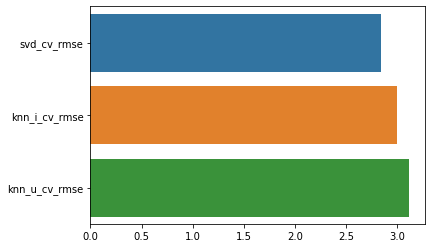

In [55]:
# Comparison of RMSE scores(mean cv) from different collaorative algorithms
sns.barplot(y=['svd_cv_rmse','knn_i_cv_rmse', 'knn_u_cv_rmse'],
            x=[svd_cv['test_rmse'].mean(),knn_i_cv['test_rmse'].mean(), knn_u_cv['test_rmse'].mean()])

# In CV also, SVD CV RMSE gives the best result.

## In what business scenario you should use popularity based Recommendation Systems ?

Popularity based recommendation systems can be useful in multiple scenarios like:

1.When there is no data about the user and items.

2.When it is required to show most popular items in different categories along with personalized results like:

    Most popular punjabi songs or most popular english songs on a music website/app
    Most popular trend in cwestern wear or traditional wear
    Most popular holiday packages for honeymoon trips, or bike trips or himalayan trips etc

## In what business scenario you should use CF based Recommendation Systems ?

Collaborative filtering is useful in scenarios like:

Giving personalised recommendation to the user, when user history or item data is available. 

Some examples can be:
Personalized movie recommendation of movie sites like Netflix, Amazon Prime, Youtube etc

## What other possible methods can you think of which can further improve the recommendation for different users ?

Other from Popularity and Collaborative Filtering, 

1.hybrid recommendation methods like Content+Collaborative method

2.Demographic

3.Utility based

4.Knowledge based recommendation system can also be used